In [1]:
import os
from square.client import Client
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from pynverse import inversefunc

SQUARE_TOKEN = os.getenv('SQUARE_TOKEN')
if not SQUARE_TOKEN:
    raise Exception('env variable SQUARE_TOKEN must be specified')
    
SQUARE_URL = 'https://connect.squareupsandbox.com'
SQUARE_ENV = 'sandbox'

# Alter these with your personal values on sandbox (or production).
ITEM_NAME = "Hamburger" # Item of interest.
LOCATION_ID = "B8VMX6KBPRJAH" # location ID for order query/creation.

# For demo purposes, will create test customers/orders in your account. 
CREATE_CUSTOMERS = False
CREATE_ORDERS = False

print('Ready, using token: ', f"{SQUARE_TOKEN[:4]}**")

Ready, using token:  EAAA**


In [2]:
client = Client(
#             square_version='2021-10-20',
            access_token=SQUARE_TOKEN,
            environment=SQUARE_ENV)
#             custom_url=SQUARE_URL,)


In [3]:
last_customer = {}

if CREATE_CUSTOMERS:
    from customer_generator import CustomerGenerator 
    customer_generator = CustomerGenerator(client)
    
    for i in range(1):
        last_customer = customer_generator.create_customer(email_address=f"test{i}@test.com")
    CREATE_CUSTOMERS = False


In [4]:
# Demo data to inject (these are different counts of sales at each given price point on an equivalent time interval, ex: 1 month)
prices = [2.99, 3.99, 4.99, 5.99, 7.99]
counts = [100, 50, 40, 20, 10]


if CREATE_ORDERS:
    from order_generator import OrderGenerator 
    order_generator = OrderGenerator(client)

    order_generator.create_random_orders(ITEM_NAME, prices, counts, LOCATION_ID, last_customer.get('id', '7V212GE0DWVYB5RE6VB24HTZT0'))
    CREATE_ORDERS = False
    


In [5]:
LIMIT = 10 # simulate an inf scenario without inf to avoid any issues with boundary condition.

class ExponentialPricer:
    
    def __init__(self, client):
        self.client = client
        self.orders_api = client.orders

    def get_sales_for_item(self, item_name, x=None, y=None): # can later add pagination
        # x: price array.
        # y: count/quantity sold corresponding to each price.
        if x and y:
            # Demo data
            x = np.array([x[0]/LIMIT, *x, x[-1]*LIMIT])
            y = np.array([y[0]*LIMIT, *y, y[-1]/LIMIT])
            return x, y
            
        body = {}
        # body['location_ids'] = ['057P5VYJ4A5X1', '18YC4JDH91E1H']
        body['query'] = {}
        body['query']['filter'] = {}
        body['limit'] = 100
        body['return_entries'] = True
        body['location_ids'] = [LOCATION_ID]

        result = self.orders_api.search_orders(body=body)
        order_ids = [x['order_id'] for x in result.body['order_entries']]
        
        # https://github.com/square/square-python-sdk/blob/master/doc/api/orders.md#batch-retrieve-orders
        # TODO: search on returned orders.
        body={'order_ids': order_ids, 'location_ids': [LOCATION_ID]}
        result = self.orders_api.batch_retrieve_orders(body=body, location_id=LOCATION_ID)

        if result.is_error():
            print(result.errors)
            raise Exception(str(result.errors))
        # TODO: iterate over quantity sold with particular item grouping by price
        orders = [x for x in result.body['orders']]
        print('Found orders', len(orders))#, orders) 
        
        price_map = {}
        customer_map = {}
        for order in orders:
            for item in order['line_items']:
                if item['name'] == ITEM_NAME:
                    usd_price = item['base_price_money']['amount']/100 # convert to dollars.
                    qty = int(item['quantity'])
                    print(f"Found: {ITEM_NAME} {usd_price} {qty}")
                    if usd_price not in price_map:
                        price_map[usd_price] = 0
                    price_map[usd_price] += qty
                    
                    customer_id = item.get('customer_id', 'N/A')
                    if usd_price not in customer_map:
                        customer_map[usd_price] = set()
                    customer_map[usd_price].add(customer_id)
            
        
        # Create price and quantity lists.
        x = []
        y = []
        for key, value in sorted(price_map.items(), key=lambda x: x[0]):
            x.append(key)
            y.append(value)
            
        x = np.array([x[0]/LIMIT, *x, x[-1]*LIMIT])
        y = np.array([y[0]*LIMIT, *y, y[-1]/LIMIT])

        return x, y, customer_map

In [6]:
pricer = ExponentialPricer(client)

In [7]:
# x, y = pricer.get_sales_for_item(ITEM_NAME, prices, counts) # demo
x, y, customer_map = pricer.get_sales_for_item(ITEM_NAME)

Found orders 6
Found: Hamburger 7.99 10
Found: Hamburger 5.99 20
Found: Hamburger 4.99 40
Found: Hamburger 3.99 50
Found: Hamburger 2.99 100


In [8]:
print('sales data', x, y)

def func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = curve_fit(func, x, y, check_finite=False, p0=(1, 1e-6, 1))
print("coefficients", popt)

sales data [ 0.299  2.99   3.99   4.99   5.99   7.99  79.9  ] [1000.  100.   50.   40.   20.   10.    1.]
coefficients [1.28519179e+03 8.75757981e-01 1.07058298e+01]


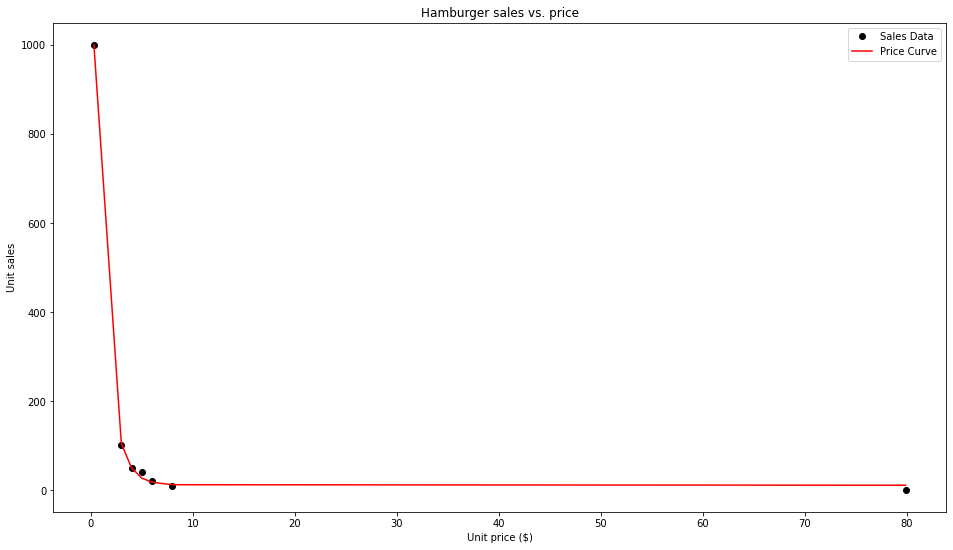

In [9]:
plt.figure(figsize=(16,9))
plt.plot(x, y, 'ko', label="Sales Data")
plt.plot(x, func(x, *popt), 'r-', label="Price Curve")
# plt.xlim(0,10)
plt.title(f"{ITEM_NAME} sales vs. price")
plt.xlabel("Unit price ($)")
plt.ylabel("Unit sales")

plt.legend()
plt.show()


In [10]:
def print_formula(a, b, c):
    return f"Units sold = {a:.2f}e^(-{b:.2f}x)+{c:.2f}, where x is the unit price in USD."

equation = print_formula(*popt)
print(equation)


print(1285.19*np.exp(-.88*2.99)+10.7) # example calculation using $2.99.



Units sold = 1285.19e^(-0.88x)+10.71, where x is the unit price in USD.
103.22342413216109


In [11]:
# Direct solution, but breaks down for small and very large values
# def inverse(y, a, b, c):
#     return -np.log((y-c)/a)/b

# Numerical inverse
sales_fit = lambda price: func(price, *popt)

price_for_sale_count = lambda count: float(max(0, inversefunc(sales_fit, y_values=count)))

In [12]:
TEST_AMOUNT = 100 # Enter a value known from the order data as a sanity check. In the example, we had 100 sales at $2.99
suggested_price = price_for_sale_count(TEST_AMOUNT)
print(f"${suggested_price:.2f}")


$3.05


In [13]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider

from IPython.display import display
# print(x[0])

In [14]:
def print_recommendation(count):
    res = price_for_sale_count(count)
    print(f"\nTo sell {count} {ITEM_NAME}s in the time interval of the found orders,\nthe recommended price is ${res:.2f}\n")
    return res

In [15]:
print('Price calculator:\n')

w = interactive(print_recommendation, 
                count=IntSlider(min=0, max=y[0]))
display(w)

Price calculator:



interactive(children=(IntSlider(value=0, description='count', max=1000), Output()), _dom_classes=('widget-inte…

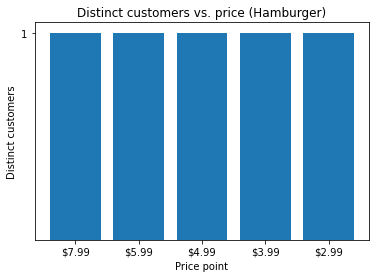

In [16]:
# Understand how customers repeat or not repeat based on different price points in your data.

def plot_customers_at_each_price_level(cust_map):
    # cust_map: Map of prices to set of distinct customer ids purchasing at that price
    price_levels = []
    distinct_customers = []
    for k,v in cust_map.items():
        price_levels.append(f"${k}") # price.
        distinct_customers.append(len(v)) # length of customer set.
        
    plt.bar(price_levels, distinct_customers)
    plt.title(f"Distinct customers vs. price ({ITEM_NAME})")
    new_list = range(math.floor(min(distinct_customers)), math.ceil(max(distinct_customers))+1)
    plt.yticks(new_list)
    plt.xlabel("Price point")
    plt.ylabel("Distinct customers")

    # plt.legend()
    plt.show()

plot_customers_at_each_price_level(customer_map)